# Machine Learning Model for Efficiency in Gold Mining

## Project Overview

### Introduction
The objective of this project is to develop a machine learning model to predict the amount of gold recovered from gold ore. This model aims to optimize the production process and eliminate unprofitable parameters for Zyfra, a company specializing in efficiency solutions for heavy industry. The dataset includes various parameters from the extraction and purification processes of gold ore.

### Data Description
The dataset contains information on different stages of the gold recovery process:
- **Rougher feed**: Raw material for flotation
- **Rougher additions**: Flotation reagents such as Xanthate, Sulphate, and Depressant
- **Rougher process**: The flotation process itself
- **Rougher tails**: Residues with low concentration of valuable metals
- **Cleaner process**: Two-stage purification resulting in final concentrate and new tails

- **Target Values**: `rougher.output.recovery` and `final.output.recovery`

The data is indexed by date and time, and some features in the training set are absent from the test set due to the timing of measurements or calculations.

### Methodology
1. **Data Preprocessing**:
    - Validate rougher.output.recovery is calculated correctly.
    - Analyze features not available in the test set and handle them appropriately.
    - Load and examine the datasets for inconsistencies or missing values.
    - Conduct data preprocessing to ensure the model performs well.

2. **Analyze the Data**:
    - Explore concentrations of metals per purification stage.
    - Compare feed particle size between the training and test set.
    - Explore the total substance concentration at each stage.
    - Make determination on any additional preprocessing needed.

3. **Model Development**:
    - Evaluate multiple models including Linear Regression, Decision Tree Regressor, Random Forest Regressor, and a baseline Dummy Regressor.
    - Use cross-validation to assess model performance and tune hyperparameters to find the best model configuration.
    - Calculate the symmetric Mean Absolute Percentage Error (sMAPE) as the evaluation metric, which considers both target values with an emphasis (75%) on the `final.output.recovery`

4. **Model Evaluation**:
    - Compare the best model with a baseline regression model predicting the mean values for each target.
    - Analyze the performance of the model in predicting `rougher.output.recovery` and `final.output.recovery` targets to identify strengths and weaknesses.

### Goals
- Develop a robust machine learning model that accurately predicts the amount of gold recovered from gold ore.
- Provide insights and recommendations based on the model's performance to improve the efficiency of the gold recovery process for Zyfra.

In [1]:
# Import Standard Libraries
import warnings

# Import Third Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

## Explore Data

In [2]:
def load_data(file_name):
    try: # Try to load the data locally from the data folder
        data = pd.read_csv(f'data/{file_name}')
    except: # Read the data from the TripTen Hub
        data = pd.read_csv(f'/datasets/{file_name}')
    
    return data

In [3]:
# Load the data
data_full = load_data('gold_recovery_full.csv')
data_train = load_data('gold_recovery_train.csv')
data_test = load_data('gold_recovery_test.csv')

# Name the dataframes
data_full.name = 'data_full'
data_train.name = 'data_train'
data_test.name = 'data_test'

In [4]:
# Define the data sets
data_sets = [data_full, data_train, data_test]

# Define the target columns
target_cols = ['rougher.output.recovery', 'final.output.recovery']

In [5]:
print(f"Train Data as a percentage of Full Data: {data_train.shape[0] / data_full.shape[0]:.2%}")
print(f"Test Data as a percentage of Full Data: {data_test.shape[0] / data_full.shape[0]:.2%}")

Train Data as a percentage of Full Data: 74.22%
Test Data as a percentage of Full Data: 25.78%


### Check that recovery is calculated correctly.  

The function for calculating recover is defined as:  
$Recovery = C × (F − T) / F × (C − T)$  
where:
- C is the share of gold in the concentrate
- F is the share of gold in the feed
- T is the share of gold in the tails

In [6]:
def calc_rough_recovery(row):

    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    if (F*(C-T)) == 0:
        recovery = 0
    else:
        recovery = ((C*(F-T))/(F*(C-T)))*100

    return recovery

In [7]:
def compare_rough_recovery(df):
    
    # Narrow the df to the necessary columns
    df = df[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']]
    
    # Drop rows with NaN values because we can only calculate and compare the recovery if we have all the necessary values
    df = df.dropna()
    
    # Calculate the recovery
    df.loc[:, 'calculated_recovery'] = df.apply(calc_rough_recovery, axis=1)
    
    # Calculate the mean absolute error
    mae = np.abs(df['rougher.output.recovery'] - df['calculated_recovery']).mean()
    
    return mae


In [8]:
print(f'The MAE for the rougher.output.recovery column in the {data_train.name} dataframe is {compare_rough_recovery(data_train)}')

The MAE for the rougher.output.recovery column in the data_train dataframe is 9.210911277458828e-15


The MAE between the recorded value for rougher.output.recovery and the calculated amount is very small, therefore we can trust values in this column.

### Analyze the features not available in the test set.
What are these parameters?  
What is their type?

In [9]:
# Print column count for each dataset
for df in data_sets:
    print(f'{df.name} column count: {len(df.columns)}')

data_full column count: 87
data_train column count: 87
data_test column count: 53


The test dataset is missing 34 columns.

In [10]:
# Assert that the full and train datasets have the same columns
assert data_full.columns.tolist() == data_train.columns.tolist()

# Assert that data_full has the same number of rows as data_train + data_test
assert data_full.shape[0] == data_train.shape[0] + data_test.shape[0]

In [11]:
# Find the columns that are missing in the test dataset
missing_cols = data_train.columns.difference(data_test.columns).tolist()

# Print the types of the columns that are missing in the test dataset
for col in missing_cols:
    print(f'{col} type: {data_train[col].dtype}')

final.output.concentrate_ag type: float64
final.output.concentrate_au type: float64
final.output.concentrate_pb type: float64
final.output.concentrate_sol type: float64
final.output.recovery type: float64
final.output.tail_ag type: float64
final.output.tail_au type: float64
final.output.tail_pb type: float64
final.output.tail_sol type: float64
primary_cleaner.output.concentrate_ag type: float64
primary_cleaner.output.concentrate_au type: float64
primary_cleaner.output.concentrate_pb type: float64
primary_cleaner.output.concentrate_sol type: float64
primary_cleaner.output.tail_ag type: float64
primary_cleaner.output.tail_au type: float64
primary_cleaner.output.tail_pb type: float64
primary_cleaner.output.tail_sol type: float64
rougher.calculation.au_pb_ratio type: float64
rougher.calculation.floatbank10_sulfate_to_au_feed type: float64
rougher.calculation.floatbank11_sulfate_to_au_feed type: float64
rougher.calculation.sulfate_to_au_concentrate type: float64
rougher.output.concentrate_a

In addition to the expected missing target values (rougher.output.recovery and final.output.recovery), the test data set is missing 32 other columns. These values are not known at the time of prediction, and should therefor be dropped from the training data set.

### Missing Values

In [12]:
# print missing value count for each data set
for df in data_sets:
    print(f'{df.name} missing value count:')
    print(df.isnull().sum().sum())

data_full missing value count:
36587
data_train missing value count:
30320
data_test missing value count:
2360


In [13]:
# Print the percentage of missing values for each column in the two data subsets
pd.set_option('display.max_rows', None)
for df in data_sets[1:]:
    print(f'{df.name} missing value percentage:')
    print(df.isnull().mean()*100)
    print()
    
pd.set_option('display.max_rows', 10)

data_train missing value percentage:
date                                                   0.000000
final.output.concentrate_ag                            0.427046
final.output.concentrate_pb                            0.427046
final.output.concentrate_sol                           2.194543
final.output.concentrate_au                            0.421115
final.output.recovery                                  9.021352
final.output.tail_ag                                   0.391459
final.output.tail_pb                                   1.085409
final.output.tail_sol                                  0.860024
final.output.tail_au                                   0.391459
primary_cleaner.input.sulfate                          7.752076
primary_cleaner.input.depressant                       7.485172
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         5.842230
primary_cleaner.output.concentrate_ag                  0.486358
pri

In [14]:
# Get percent of rows with NaN values in any column for the two data subsets
for df in data_sets[1:]:
    print(f'{df.name} rows with NaN values: {df.isnull().any(axis=1).mean()*100:.2f}%')

data_train rows with NaN values: 34.66%
data_test rows with NaN values: 8.08%


In [15]:
# Print percent of rows with NaN values in target columns in the full dataset
print(f'{data_full.name} rows with NaN values in target columns: {data_full[target_cols].isnull().any(axis=1).mean()*100:.2f}%')

data_full rows with NaN values in target columns: 14.43%


There are significant percentages of missing values across both axises. Dropping nearly 35% of rows in the training data is clearly not a viable option. Dropping columns is also not an ideal solution, since we want as many features as possible for prediction (and we would still have plenty of rows with missing values). Thankfully, we know from the project description that "Parameters that are next to each other in terms of time are often similar.", therefor we can forward fill missing feature values. We will, however, have to drop rows with missing values in either target, which accounts for about 14% of the total data (we want to train our model only on actual results).

## Data Preprocessing

Based on the discoveries from exploring the data, the following steps will be taken to preprocess the data for the task at hand:

1. Drop rows where either target is missing from full dataset.
2. Be sure full dataset is organized by date, then forward fill missing values (because "Parameters that are next to each other in terms of time are often similar."). Check no missing values.
3. Redefine the test df and train df as inner merge on date with full data set, drop necessary columns

In [16]:
# Drop rows with NaN values in the target columns
data_full = data_full.dropna(subset=target_cols)

# Sort full dataset by date
data_full = data_full.sort_values('date')
# Forward fill the missing values
data_full = data_full.fillna(method='ffill')
# Assert no missing values
assert data_full.isnull().sum().sum() == 0


# Define the drop columns
drop_cols = [col for col in missing_cols if col not in target_cols]

# Redefine the train data set as inner join of train dates and full data, will exclude the dropped missing target values
data_train_dates = data_train['date'].to_frame()
data_train = data_train_dates.merge(data_full, on='date', how='inner')
# Drop the drop columns
data_train = data_train.drop(drop_cols, axis=1)

# Redefine the test data set as inner join of test dates and full data, will exclude the dropped missing target values
data_test_dates = data_test['date'].to_frame()
data_test = data_test_dates.merge(data_full, on='date', how='inner')
# Drop the drop columns (target columns kept for final testing)
data_test = data_test.drop(drop_cols, axis=1)

# Assert no missing values in the subsets
assert data_train.isnull().sum().sum() == 0
assert data_test.isnull().sum().sum() == 0

# Assert the data_test columns equal the data_train columns
assert data_test.columns.tolist() == data_train.columns.tolist()

# Assert the data_full rows equal the data_train rows plus the data_test rows
assert data_full.shape[0] == data_train.shape[0] + data_test.shape[0]

# Name the dataframes
data_full.name = 'data_full'
data_train.name = 'data_train'
data_test.name = 'data_test'

data_sets = [data_full, data_train, data_test]

In [17]:
# Print the shapes of the data sets
for data in data_sets:
    print(f'{data.name} shape: {data.shape}')

data_full shape: (19439, 87)
data_train shape: (14149, 55)
data_test shape: (5290, 55)


In [18]:
print(f"Train Data as percentage of Full Data: {data_train.shape[0]/data_full.shape[0]*100:.2f}%")
print(f"Test Data as percentage of Full Data: {data_test.shape[0]/data_full.shape[0]*100:.2f}%")

Train Data as percentage of Full Data: 72.79%
Test Data as percentage of Full Data: 27.21%


After preprocessing the data, the share of train data to test data is within 2% of the original share and remains an appropriate split.

## Analyze the Data

In [19]:
# Print the min and max date for each dataset
for df in data_sets:
    print(f'{df.name} min date: {df["date"].min()}, max date: {df["date"].max()}')

data_full min date: 2016-01-15 00:00:00, max date: 2018-08-18 10:59:59
data_train min date: 2016-01-15 00:00:00, max date: 2018-08-18 10:59:59
data_test min date: 2016-09-01 00:59:59, max date: 2017-12-31 23:59:59


### Concentrations of metals (Au, Ag, Pb) per purification stage.

In [20]:
metals = ['au', 'ag', 'pb']

def sort_metal_concentration_columns():    
    metal_conc_cols = [col for col in data_full.columns if any(".concentrate_" + metal in col for metal in metals)]

# Define order of metals and stages
    metal_order = {'au': 1, 'ag': 2, 'pb': 3}
    stage_order = {'rougher': 1, 'primary_cleaner': 2, 'final': 3}

# Sort the columns based on metal and stage
    sorted_metal_conc_cols = sorted(
    metal_conc_cols,
    key=lambda col: (
        metal_order[col.split('_')[-1]],  # metal order
        stage_order[col.split('.')[0]],  # stage order 
    )
)

    return sorted_metal_conc_cols

metal_conc_cols = sort_metal_concentration_columns()

print(metal_conc_cols)

['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']


In [21]:
def plot_metal_concentration(data, metal_conc_cols, metal):
    # Narrow list of columns to the metal of interest
    metal_conc_cols = [col for col in metal_conc_cols if metal in col]
    
    # Set the figure size
    fig = plt.figure(figsize=(6,4))  # Adjust the figure size as needed
    
    # hist plot with density of the metal concentration columns
    for col in metal_conc_cols:
        sns.histplot(data[col], kde=True, stat="density", label=col)
    
    # Set the title
    plt.title(f'{metal.upper()} Concentration per Stage')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')  # Set the legend outside of the plot
    
    # Set x-axis min to 0
    plt.xlim(0, None)
    # Set x-axis label
    plt.xlabel('Concentration')
    
    return fig  # Return the figure object

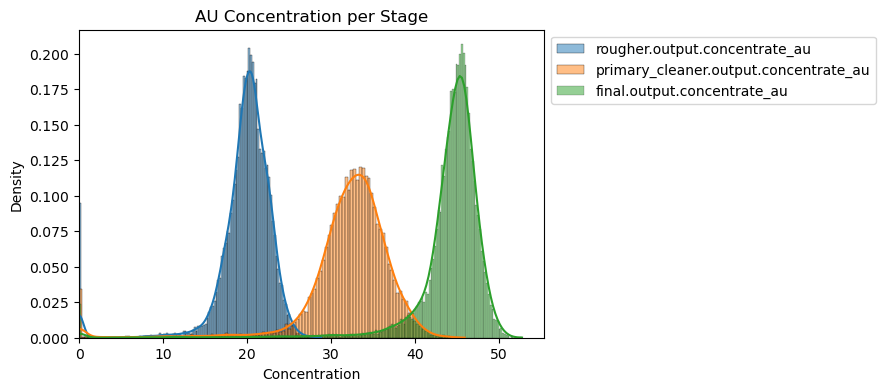

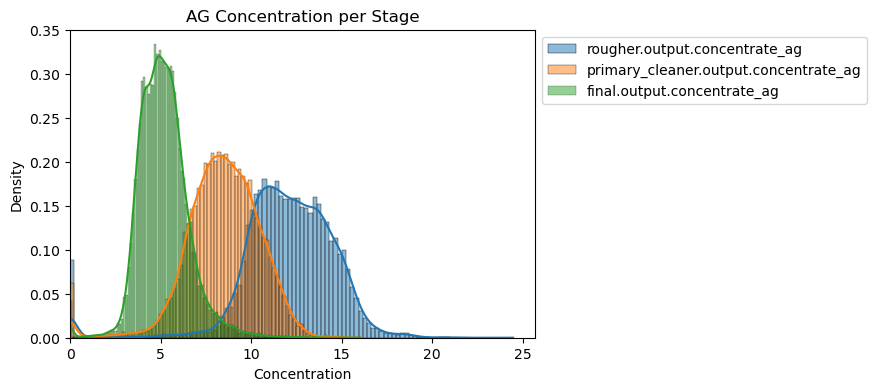

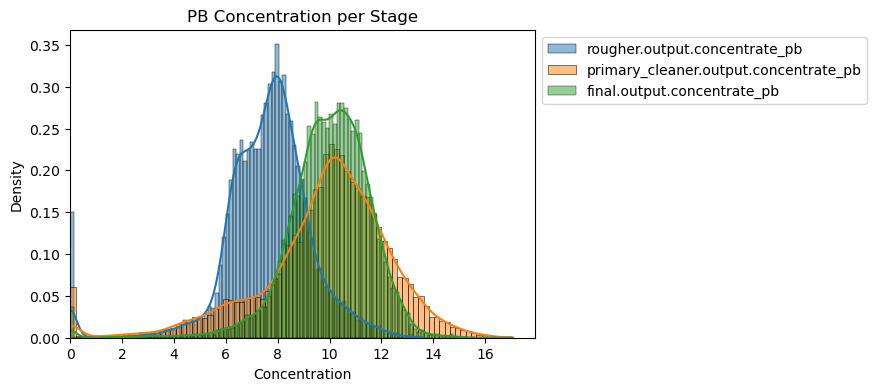

In [22]:
plot_metal_concentration(data_full, metal_conc_cols, 'au')
plot_metal_concentration(data_full, metal_conc_cols, 'ag')
plot_metal_concentration(data_full, metal_conc_cols, 'pb');

#### Findings

- Gold (AU): As the refining process progress, the concentration of gold increases steadily. This is to be expected, as gold is the product in this process. 
- Silver (AG): Silver concentration moves in the opposite direction of gold concentration, decreasing at every step of the process.
- Lead (PB): Generally remains the same throughout the process, increasing slightly from the rougher to primary stage, then remaining around the same in the final stage with more concentration around the mean. 

### Compare the feed particle size between the training set and test set.
If the distributions vary significantly, the model evaluation will be incorrect.

In [23]:
# Define the feed size columns
feed_size_cols = [col for col in data_full.columns if 'feed_size' in col]

# Reverse the order
feed_size_cols = feed_size_cols[::-1]

print(feed_size_cols)

['rougher.input.feed_size', 'primary_cleaner.input.feed_size']


In [24]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def compare_feed_size(col):
    """
    Plots col distribution for the train and test datasets.
    """
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # Set the figure title
    fig.suptitle(f'{col} Distribution Comparison')
    
    # hist plot with density of the col for the train and test datasets
    sns.histplot(data_train[col], kde=True, stat="density", label='Train', ax=ax[0])
    sns.histplot(data_test[col], kde=True, stat="density", label='Test', ax=ax[0])
    # Set the title
    ax[0].set_title('Distribution')
    # Set the legend
    ax[0].legend()
    # Set x-axis min to 0
    ax[0].set_xlim(0, None)
    # Set x-axis label
    ax[0].set_xlabel("Feed Particle Size")
    
    
    # Calculate ECDF
    eCDF_train_x, eCDF_train_y = ecdf(data_train[col])
    eCDF_test_x, eCDF_test_y = ecdf(data_test[col])
    # Plot the ECDF
    ax[1].plot(eCDF_train_x, eCDF_train_y, label='Train')
    ax[1].plot(eCDF_test_x, eCDF_test_y, label='Test')
    # Set the title
    ax[1].set_title('Empirical Cumulative Distribution')
    # Set the labels
    ax[1].set_xlabel('Feed Particle Size')
    ax[1].set_ylabel('ECDF')
    ax[1].legend()

    fig.tight_layout()
     
    return fig

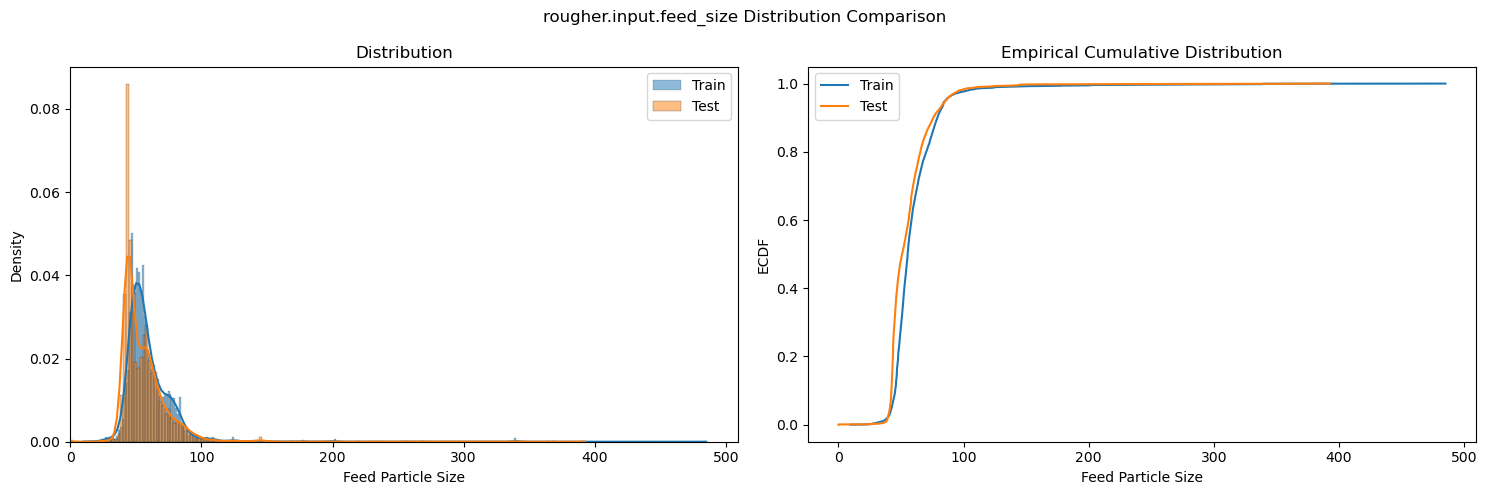

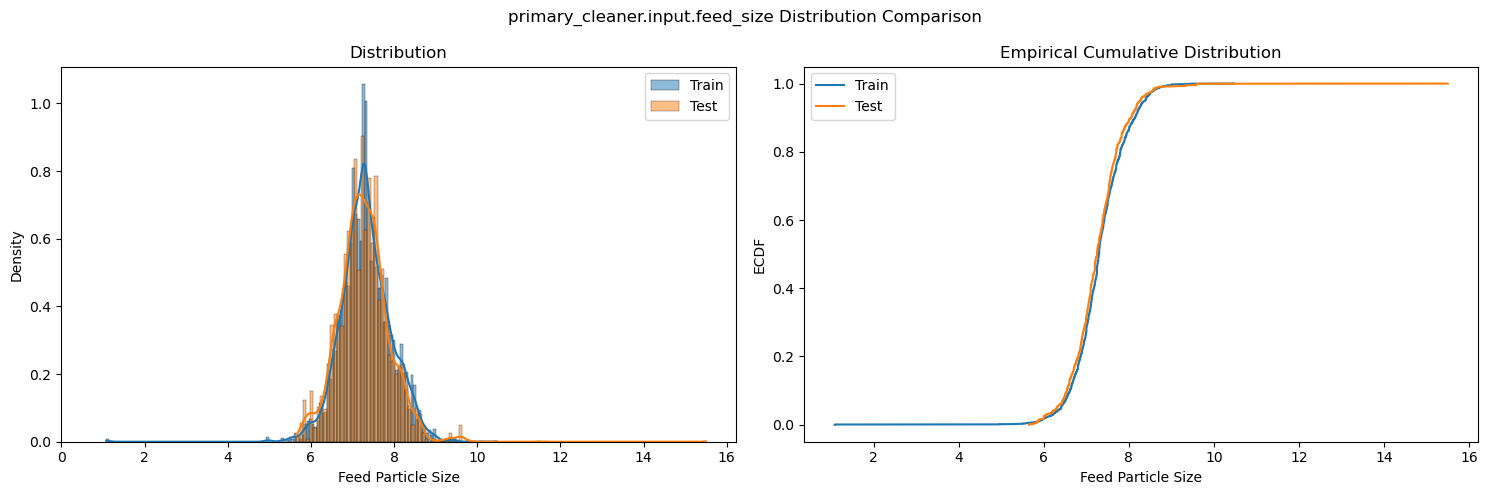

In [25]:
fig = compare_feed_size(feed_size_cols[0])
plt.show()  # Display the plot

fig = compare_feed_size(feed_size_cols[1])
plt.show()  # Display the plot

#### Findings
Upon visual inspection of both particle feed size columns ('primary_cleaner.input.feed_size' and 'rougher.input.feed_size'), it can be determined that the distributions between the train and test set do not differ significantly. This is most clearly illustrated by plotting the empirical cumulative distribution. Additional steps to balance these features is not necessary. 

### Consider the total concentrations of all substances at different stages

In [26]:
def plot_total_concentration():
    # Define Raw feed columns
    raw_feed_conc_cols = [col for metal in metals for col in data_full.columns if 'feed' in col and 'input' in col and metal in col]
    # Define rougher concentrate columns
    rougher_conc_cols = [col for metal in metals for col in data_full.columns if 'concentrate' in col and 'rougher' in col and metal in col and 'calculation' not in col]
    # Define final concentrate columns
    final_conc_cols = [col for metal in metals for col in data_full.columns if 'concentrate' in col and 'final' in col and metal in col]

    # Add the columns for total concentration
    raw_feed_total_conc = data_full[raw_feed_conc_cols].sum(axis=1)
    rougher_total_conc = data_full[rougher_conc_cols].sum(axis=1)
    final_total_conc = data_full[final_conc_cols].sum(axis=1)

    # Plot the total concentration columns
    fig = plt.figure(figsize=(8, 6))
    sns.histplot(raw_feed_total_conc, kde=True, stat="density", label='Raw Feed')
    sns.histplot(rougher_total_conc, kde=True, stat="density", label='Rougher Concentrate')
    sns.histplot(final_total_conc, kde=True, stat="density", label='Final Concentrate')
    plt.title('Total Substance Concentration Distribution')
    plt.legend()
    plt.xlabel('Sum of Concentration (AU, AG, PB)')
    plt.xlim(0, None)

    return fig

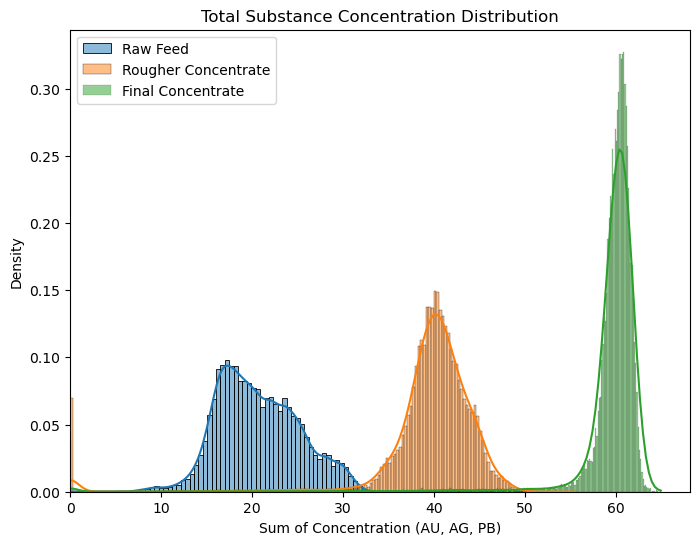

In [27]:
fig = plot_total_concentration()

#### Findings
As the process progresses, the total concentration of all substances measured increases and condenses toward the mean value. This is to be expected, and generally reflects the pattern of the target substance (gold).

## Build the Model


### Prepare Data for Training

In [28]:
# Set Global Random Seed
state = np.random.RandomState(12345)

# Drop the date column from the train and test datasets, as it is not needed for training
data_train = data_train.drop('date', axis=1)
data_test = data_test.drop('date', axis=1)

# Shuffle both datasets so they are not in chronological order, as this could bias the model
data_train = data_train.sample(frac=1, random_state=state).reset_index(drop=True)
data_test = data_test.sample(frac=1, random_state=state).reset_index(drop=True)

# Define the features
X_train = data_train.drop(target_cols, axis=1)
# Define the targets
y_train = data_train[target_cols]

# Feature scaling will be done within the cross-validation pipeline for model training

In [29]:
if input("input 'y' to train models, any other input will use hard coded values to avoid the lengthy process of training the decision trees and random forests (sMAPE values stored up to the 4th decimal point)") == 'y':
    train_models = True
else:
    train_models = False

### sMAPE Functions

In [30]:
def smape(y_true, y_pred):
    """
    Calculate the symmetric Mean Absolute Percentage Error (sMAPE).

    Parameters:
    y_true (numpy array or list): Array of actual values.
    y_pred (numpy array or list): Array of predicted values.

    Returns:
    float: sMAPE value.
    """
    # Ensure inputs are arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the denominator
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Handle the case where both y_true and y_pred are zero
    denominator = np.where((y_true == 0) & (y_pred == 0), 1, denominator) # checks if both y_true and y_pred are zero at the same time. If they are, it sets the denominator to 1 (since 0/1 = 0).
    
    N = len(y_true)
    smape_value = (1 / N) * np.sum(np.abs(y_true - y_pred) / denominator) * 100
    
    return smape_value

def final_smape(y_true, y_pred):
    """
    Calculate the final sMAPE.

    Parameters:
    y_true (numpy array): Array with the actual values.
    y_pred (numpy array): Array with the predicted values.
    
    Returns:
    float: Final sMAPE value.
    """
    # Ensure inputs are arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the rougher and final sMAPE
    rougher_output_smape = smape(y_true[:, 0], y_pred[:, 0])
    final_output_smape_value = smape(y_true[:, 1], y_pred[:, 1])
    
    # Calculate the final sMAPE
    final_smape_value = (0.25 * rougher_output_smape) + (0.75 * final_output_smape_value)
    
    return final_smape_value

# Convert final_smape to a scorer
final_smape_scorer = make_scorer(final_smape)

### Linear Regressor

In [31]:
def train_linear_regrssor():

    # Create a pipeline that first scales the features and then fits the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])

    # Perform cross-validation on the pipeline
    lin_reg_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=final_smape_scorer)
    lin_reg_score = lin_reg_scores.mean()

    return lin_reg_score

In [32]:
lin_reg_score = train_linear_regrssor()
print(f'Linear Regression sMAPE: {lin_reg_score:.4f}')

Linear Regression sMAPE: 9.3151


### Decision Tree Regressor

In [33]:
def train_decision_tree():
    best_score = 1000 # Something impossibly high
    best_depth = 'Not Set'

    # Range of depths including None
    depths = [None] + list(range(1, 21))

    with tqdm(total=len(depths)) as pbar:
        for depth in depths:
            # Create a pipeline with a Decision Tree Regressor
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', DecisionTreeRegressor(max_depth=depth, random_state=state))
            ])

            # Perform cross-validation on the pipeline
            scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=final_smape_scorer)
            average_score = scores.mean()

            # Update the best score and best depth if the current score is better
            if average_score < best_score:
                best_score = average_score
                best_depth = depth

            pbar.update(1)
    
    return best_score, best_depth


In [34]:
if train_models:
    decision_tree_score, decision_tree_depth = train_decision_tree()
else: # Best values hard coded to avoid training the model
    decision_tree_score = 8.1695
    decision_tree_depth = 16
    
print(f'Decision Tree Final sMAPE: {decision_tree_score:.4f} with max depth of {decision_tree_depth}')

Decision Tree Final sMAPE: 8.1695 with max depth of 16


### Random Forrest Regressor

In [35]:
def train_random_forrest():
    
    # Define best score, depth, and estimators
    best_score = 1000 # Something impossibly high
    best_depth = 'Not Set'
    best_estimators = 'Not Set'
    
    # Range of depths including None
    depths = range(16, 27, 2)
    # Range of estimators
    estimators = [100, 200] 
    
    with tqdm(total=len(depths)*len(estimators), unit='iterations') as pbar:
        for depth in depths:
            for n_estimators in estimators:
                # Create a pipeline with a Random Forest Regressor
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('model', RandomForestRegressor(max_depth=depth, n_estimators=n_estimators, random_state=state))
                ])

                # Perform cross-validation on the pipeline
                scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=final_smape_scorer)
                average_score = scores.mean()

                # Update the best score, depth, and estimators if the current score is better
                if average_score < best_score:
                    best_score = average_score
                    best_depth = depth
                    best_estimators = n_estimators
            
                # Update the progress bar
                pbar.update(1)
                
    return best_score, best_depth, best_estimators

In [36]:
if train_models:
    random_forest_score, random_forest_depth, random_forest_estimators = train_random_forrest()
else: # Best values hard coded to avoid training the model
    random_forest_score = 6.7610
    random_forest_depth = 26
    random_forest_estimators = 200

print(f'Random Forest Final sMAPE: {random_forest_score:.4f} with max depth of {random_forest_depth} and {random_forest_estimators} estimators')

Random Forest Final sMAPE: 6.7610 with max depth of 26 and 200 estimators


### Test the Best Model
Three regression models have been trained with varying tuning parameters. With regard to the specified ranges of tested tuning parameters, the performance of each model are as follows:

- **Linear Regressor**: sMAPE = 9.3151
- **Decision Tree Regressor**: sMAPE = 8.1695
- **Random Forrest Regressor**: sMAPE = 6.7610

In [37]:
# Prepare the test data for prediction
X_test = data_test.drop(target_cols, axis=1)
y_test = data_test[target_cols]

In [38]:
# Create a pipeline with the best Random Forest Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(max_depth=random_forest_depth, n_estimators=random_forest_estimators, random_state=state))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)
# Predict the target values
y_pred = pipeline.predict(X_test)

# Calculate the final sMAPE
best_model_smape = final_smape(y_test, y_pred)


print(f'Final sMAPE for the best model: {best_model_smape:.4f}')

Final sMAPE for the best model: 10.2491


In [39]:
# Create a dummy regressor for comparison

dummy_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DummyRegressor(strategy='mean'))
])

# Fit the pipeline to the training data
dummy_pipeline.fit(X_train, y_train)
# Predict the target values
dummy_y_pred = dummy_pipeline.predict(X_test)

# Calculate the final sMAPE
dummy_smape = final_smape(y_test, dummy_y_pred)

print(f'Final sMAPE for the dummy model: {dummy_smape:.4f}')

Final sMAPE for the dummy model: 10.2896


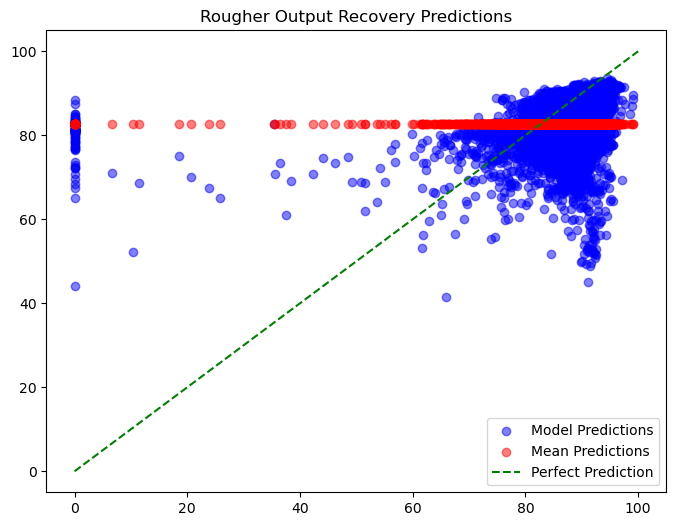

In [40]:
# Plot the predictions for the rougher.output.recovery column
plt.figure(figsize=(8, 6))
# Plot the predicted values for the rougher.output.recovery column
plt.scatter(y_test.iloc[:, 0], y_pred[:, 0], alpha=0.5, color='blue')
# Plot the DummyRegressor predictions
plt.scatter(y_test.iloc[:, 0], dummy_y_pred[:, 0], alpha=0.5, color='red')

# Plot the line of perfect predictions
plt.plot([0, 100], [0, 100], color='green', linestyle='--')

plt.title('Rougher Output Recovery Predictions')
plt.legend([ 'Model Predictions', 'Mean Predictions', 'Perfect Prediction'], loc='lower right')


plt.show()

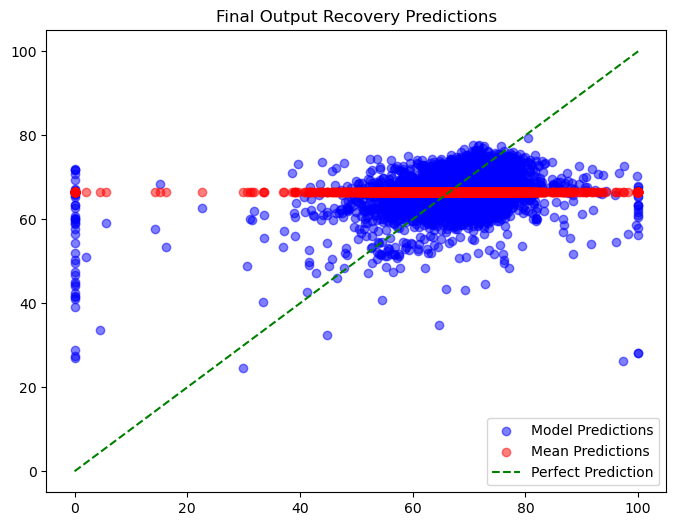

In [41]:
# Plot the predictions for the final.output.recovery column
plt.figure(figsize=(8, 6))
# Plot the target values and the predicted values for the final.output.recovery column
plt.scatter(y_test.iloc[:, 1], y_pred[:, 1], alpha=0.5, color='blue')
# Plot the DummyRegressor predictions
plt.scatter(y_test.iloc[:, 1], dummy_y_pred[:, 1], alpha=0.5, color='red')
# Plot the line of perfect predictions
plt.plot([0, 100], [0, 100], color='green', linestyle='--')

plt.title('Final Output Recovery Predictions')
plt.legend([ 'Model Predictions', 'Mean Predictions', 'Perfect Prediction'], loc='lower right')

plt.show()


#### Findings
The best model with the best parameters performs only marginally better (sMAPE = 10.0919) compared to a baseline regression model predicting the mean values for each target (sMAPE = 10.2896). Plotting the model predictions and the dummy predictions illuminates this further. The model does a significantly better job of predicting the rougher.output.recovery target than the using the mean value prediction, we can see a more general adherence to the line of perfect prediction. However, when it comes to predicting the final.output.recovery target, the model's predictions cluster around the mean value much more so than the line of perfect prediction. Considering the final sMAPE calculation heavily favors the sMAPE score for the final.output.recovery target, this is explains the near match in final sMAPE scores between the best model and dummy model predictions. 

## Conclusion

In this project, we developed a machine learning model to predict the amount of gold recovered from gold ore, aiming to optimize the production process for Zyfra. The process involved extensive data preprocessing and the evaluation of multiple models (Linear Regression, Decision Tree Regressor, Random Forest Regressor, and a baseline Dummy Regressor). The best model was a Random Forrest Regressor with a max depth of 26 and 200 estimators. This model achieved only marginal improvement over the baseline, highlighting areas for further enhancement.

### Recommendation:
Based on the model’s performance, I recommend exploring more computationally expensive hyperparameters and other advanced machine learning models to capture complex relationships in the data. Additionally, incorporating domain-specific features and conducting detailed exploratory data analysis will further improve model accuracy and efficiency.